In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import zipfile


# Unzip the downloaded file
zip_ref = zipfile.ZipFile(data_dir+'train.zip', "r")
zip_ref.extractall(path=data_dir)
zip_ref.close()

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
#Create function to read lines

def get_lines(filename):
  '''
  Reads filename and returns the lines of text as a list.

  Args:
  ----
    A string containing the target filepath to read.

  Returns:
    A list of strings with one string per line from the target filepath.
    For Eaxmple:
      ['This is first line of the filepath',
       'This is second line of the filepath',
       .....]
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returning a list of dictionaries of abstract line data.

  Takes in filename, read its contents and sorts thorugh each line.
  extracting things like target labels, texts of the sentences.
  How many sentences are in the current abstract and what sentence number the target line is.


  Arg:
    The string containing target text filepath to read texts and extarct line data from.


  Returns:
    An list of dictionries each containing a line from an abstract.
    The line label, line position at the abstract and total
    number of lines in the abstract where the line is from.

    For Example:
      [{target: OBJECTIVE,
        text: this is the text.
        line_number: 2,
        total_lines: 5}]

  '''

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_sample = []

  # Loop through each line of target files.
  for line in input_lines:
    if line.startswith('###'): #Check to see the line is an ID line.
      abstract_ID = line
      abstract_lines = '' # reset abstract string.
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() #split abstract into sperate lines.


      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create a dict to store abstract line data
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1]
        line_data['line_number'] = abstract_line_number
        line_data['total_line'] = len(abstract_line_split)-1
        abstract_sample.append(line_data)

    else:
      abstract_lines += line

  return abstract_sample


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 3.75 s, sys: 890 ms, total: 4.64 s
Wall time: 5.2 s


(2211861, 28932, 29493)

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(24)

,target,text,line_number,total_line
0,BACKGROUND,The emergence of HIV as a chronic condition me...,0,10
1,BACKGROUND,This paper describes the design and evaluation...,1,10
2,METHODS,This study is designed as a randomised control...,2,10
3,METHODS,The intervention group will participate in the...,3,10
4,METHODS,The program is based on self-efficacy theory a...,4,10
5,METHODS,Participants will access the program for a min...,5,10
6,METHODS,Primary outcomes are domain specific self-effi...,6,10
7,METHODS,"Secondary outcomes include : depression , anxi...",7,10
8,METHODS,"Data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,Results of the Positive Outlook study will pro...,9,10


In [ ]:
# Convert abstract lines into list
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# make function to split sentences into characters.
def split_chars(text):
  return ' '.join(list(text))

# test split_chars function.
#split_chars(random_training_sentence)

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])


T h e   e m e r g e n c e   o f   H I V   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   H I V   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .


In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
train_chars_batch = tf.data.Dataset.from_tensor_slices(train_chars)


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

In [ ]:
# Create char-level token vectorizer instance
from tensorflow.keras.layers import TextVectorization

NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars_batch.batch(32))

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
#print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
#char_embed_example = char_embed(char_vectorizer([random_train_chars]))
#print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
#print(f"Character embedding shape: {char_embed_example.shape}")

In [ ]:
train_df['line_number'].value_counts()

0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

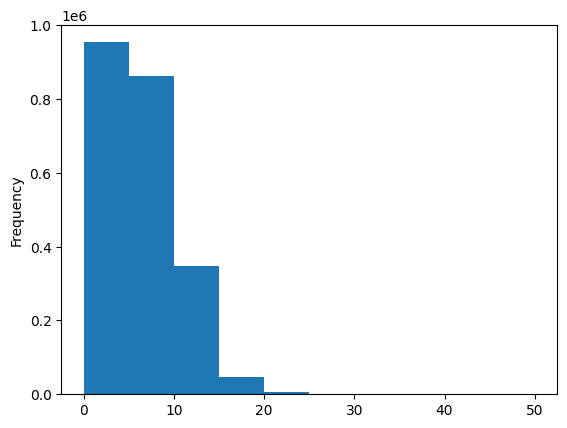

In [ ]:
# Check the distribution
train_df['line_number'].plot.hist()

In [ ]:
# Check the coverage of a "line_number"
np.percentile(train_df.line_number, 98) # a value of 15 covers 98% of samples


15.0

In [ ]:
# Create one_hot_encoded tensor for line number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [ ]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([2211861, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

In [ ]:
# How many different numbers of lines are there?
train_df["total_line"].value_counts()

10    304733
11    303648
12    266682
9     259640
13    212296
8     183168
14    156015
15    111712
7     110240
16     74987
6      53088
17     48672
18     31502
19     22100
5      21174
20     13797
21      9988
4       6385
22      5750
23      3984
24      2750
25      1924
26      1485
27      1148
3       1148
28       870
29       720
33       442
31       416
30       279
32       264
35       180
34       140
37       114
36       111
50        51
49        50
46        47
45        46
43        44
40        41
2         30
Name: total_line, dtype: int64

<Axes: ylabel='Frequency'>

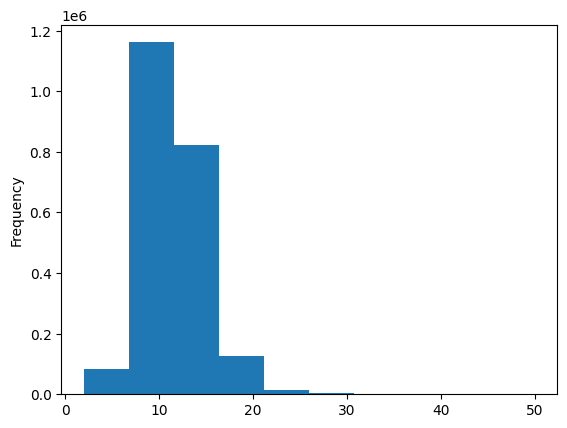

In [ ]:
train_df['total_line'].plot.hist()

In [ ]:
np.percentile(train_df['total_line'], 98)

20.0

In [ ]:
# Create one hot tensor for total line column.
train_total_line_numbers_one_hot = tf.one_hot(train_df['total_line'].to_numpy(), depth=20)
val_total_line_numbers_one_hot = tf.one_hot(val_df['total_line'].to_numpy(), depth=20)
test_total_line_numbers_one_hot = tf.one_hot(test_df['total_line'].to_numpy(), depth=20)

In [ ]:
train_total_line_numbers_one_hot.shape, train_total_line_numbers_one_hot[:20]

(TensorShape([2211861, 20]),
 <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 284)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

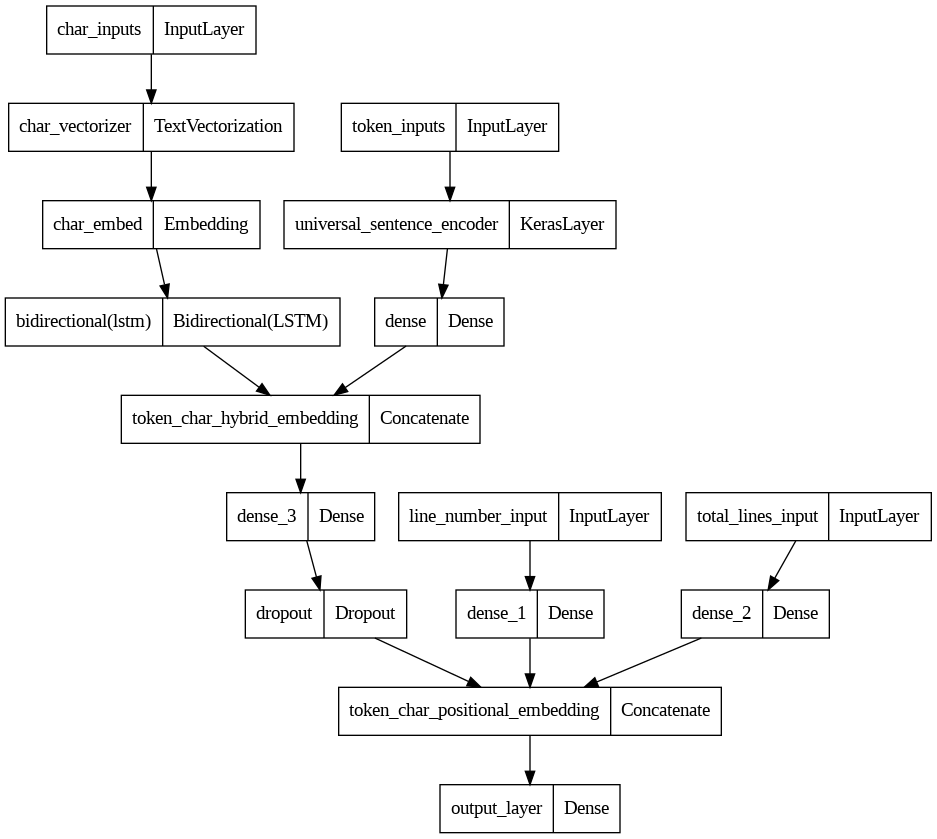

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b9316573850> True
<keras.src.engine.input_layer.InputLayer object at 0x7b9316573eb0> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7b9432cae3e0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7b943372dab0> False
<keras.src.layers.core.embedding.Embedding object at 0x7b943a8f72e0> True
<keras.src.layers.core.dense.Dense object at 0x7b931646b2e0> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7b9316507700> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7b9316615330> True
<keras.src.engine.input_layer.InputLayer object at 0x7b931652dc60> True
<keras.src.engine.input_layer.InputLayer object at 0x7b93164fa1a0> True
<keras.src.layers.core.dense.Dense object at 0x7b9316479390> True
<keras.src.layers.core.dense.Dense object at 0x7b93165078b0> True
<keras.src.layers.core.dense.Dense object at 0x7b93164f8d60> True
<keras.src.layers.regularization.dropout.

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_line_numbers_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_line_numbers_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=len(train_pos_char_token_dataset),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=len(val_pos_char_token_dataset))

Epoch 1/3
69121/69121 [==============================] - 2263s 32ms/step - loss: 0.8999 - accuracy: 0.8575 - val_loss: 0.8728 - val_accuracy: 0.8733
Epoch 2/3
69121/69121 [==============================] - 2232s 32ms/step - loss: 0.8801 - accuracy: 0.8709 - val_loss: 0.8628 - val_accuracy: 0.8791
Epoch 3/3
69121/69121 [==============================] - 2206s 32ms/step - loss: 0.8742 - accuracy: 0.8748 - val_loss: 0.8603 - val_accuracy: 0.8789


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

905/905 [==============================] - 18s 19ms/step


array([[0.5803465 , 0.06829211, 0.02432436, 0.23081367, 0.09622331],
       [0.15763895, 0.02644684, 0.6581599 , 0.10999632, 0.04775799],
       [0.22292978, 0.09624139, 0.16527583, 0.13434105, 0.381212  ],
       ...,
       [0.06547093, 0.52350235, 0.0653358 , 0.04979205, 0.2958989 ],
       [0.0455192 , 0.37271872, 0.04244496, 0.03907499, 0.5002421 ],
       [0.04975465, 0.82449543, 0.01988504, 0.03753636, 0.06832851]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 1, 4, 1])>

In [ ]:
model_5.evaluate(val_pos_char_token_dataset)

905/905 [==============================] - 18s 20ms/step - loss: 0.8603 - accuracy: 0.8789


[0.8602719902992249, 0.8788884282112122]

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''
  Calculate model accuracy, precision, recall and f1-score of a classification model.

  Args:
    y_true: true labels in the form of 1D array.
    y_pred: predicted labels in the form of 1D array.

  Returns:
    It's returns a dictionary of model accuracy, precision,
    recall, f1_score.

  '''

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 87.88884280381585,
 'precision': 0.8814551574290604,
 'recall': 0.8788884280381585,
 'f1': 0.877244270502592}

<Axes: >

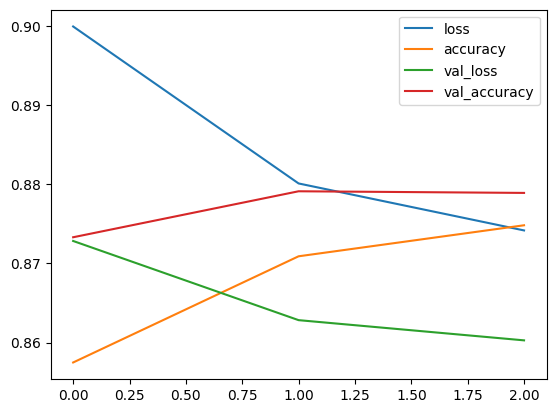

In [ ]:
import pandas as pd
pd.DataFrame(history_model_5.history).plot()

Save and load best performing model

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")